In [1]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


#### Retrieve the dataset and set index as the date that is being used in the dataset.

In [2]:
data_dir = Path("../datasets/others")
merge_data = pd.read_csv(data_dir / "merge-date.csv")

merge_data.set_index(
    pd.PeriodIndex(merge_data.date, freq="h"),
    inplace=True,
)

#### Choose the columns that would be used and group the data by postal code.

In [3]:
merge_data = merge_data[['PC4','pm2.5']]
merge_data_per_zip = dict(tuple(merge_data.groupby('PC4')))

#### Choose postal code that would be used.

In [4]:
merge_data_pc_industrial = merge_data_per_zip[5651]
merge_data_pc_center = merge_data_per_zip[5611]
merge_data_pc_residential =  merge_data_per_zip[5654]

#### Select which days that would be used.

In [5]:
startDate = '2021-09-25'
endDate = '2021-09-30'

merge_data_pc_industrial = merge_data_pc_industrial[(merge_data_pc_industrial.index >= startDate) & (merge_data_pc_industrial.index <= endDate)]
merge_data_pc_residential = merge_data_pc_residential[(merge_data_pc_residential.index >= startDate) & (merge_data_pc_residential.index <= endDate)]
merge_data_pc_center = merge_data_pc_center[(merge_data_pc_center.index >= startDate) & (merge_data_pc_center.index <= endDate)]
# merge_data_pc_industrial

#### Create lags and steps to be used for forecasting.

In [6]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

# Industrial Area

#### Lags and steps of industrial postal code

In [7]:
# Four weeks of lag features
y = merge_data_pc_industrial['pm2.5'].copy()
X = make_lags(y, lags=24).fillna(0.0)

# Eight-week forecast
y = make_multistep_target(y, steps=10).dropna()
y, X = y.align(X, join='inner', axis=0)

# print(X)
# print(y)

#### Split the data into traing and testing data, using the MultiOutputRegressor as the model.

In [8]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)

y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

#### Graph the trained data and forecasting data.

Train RMSE: 0.00
Test RMSE: 4.71


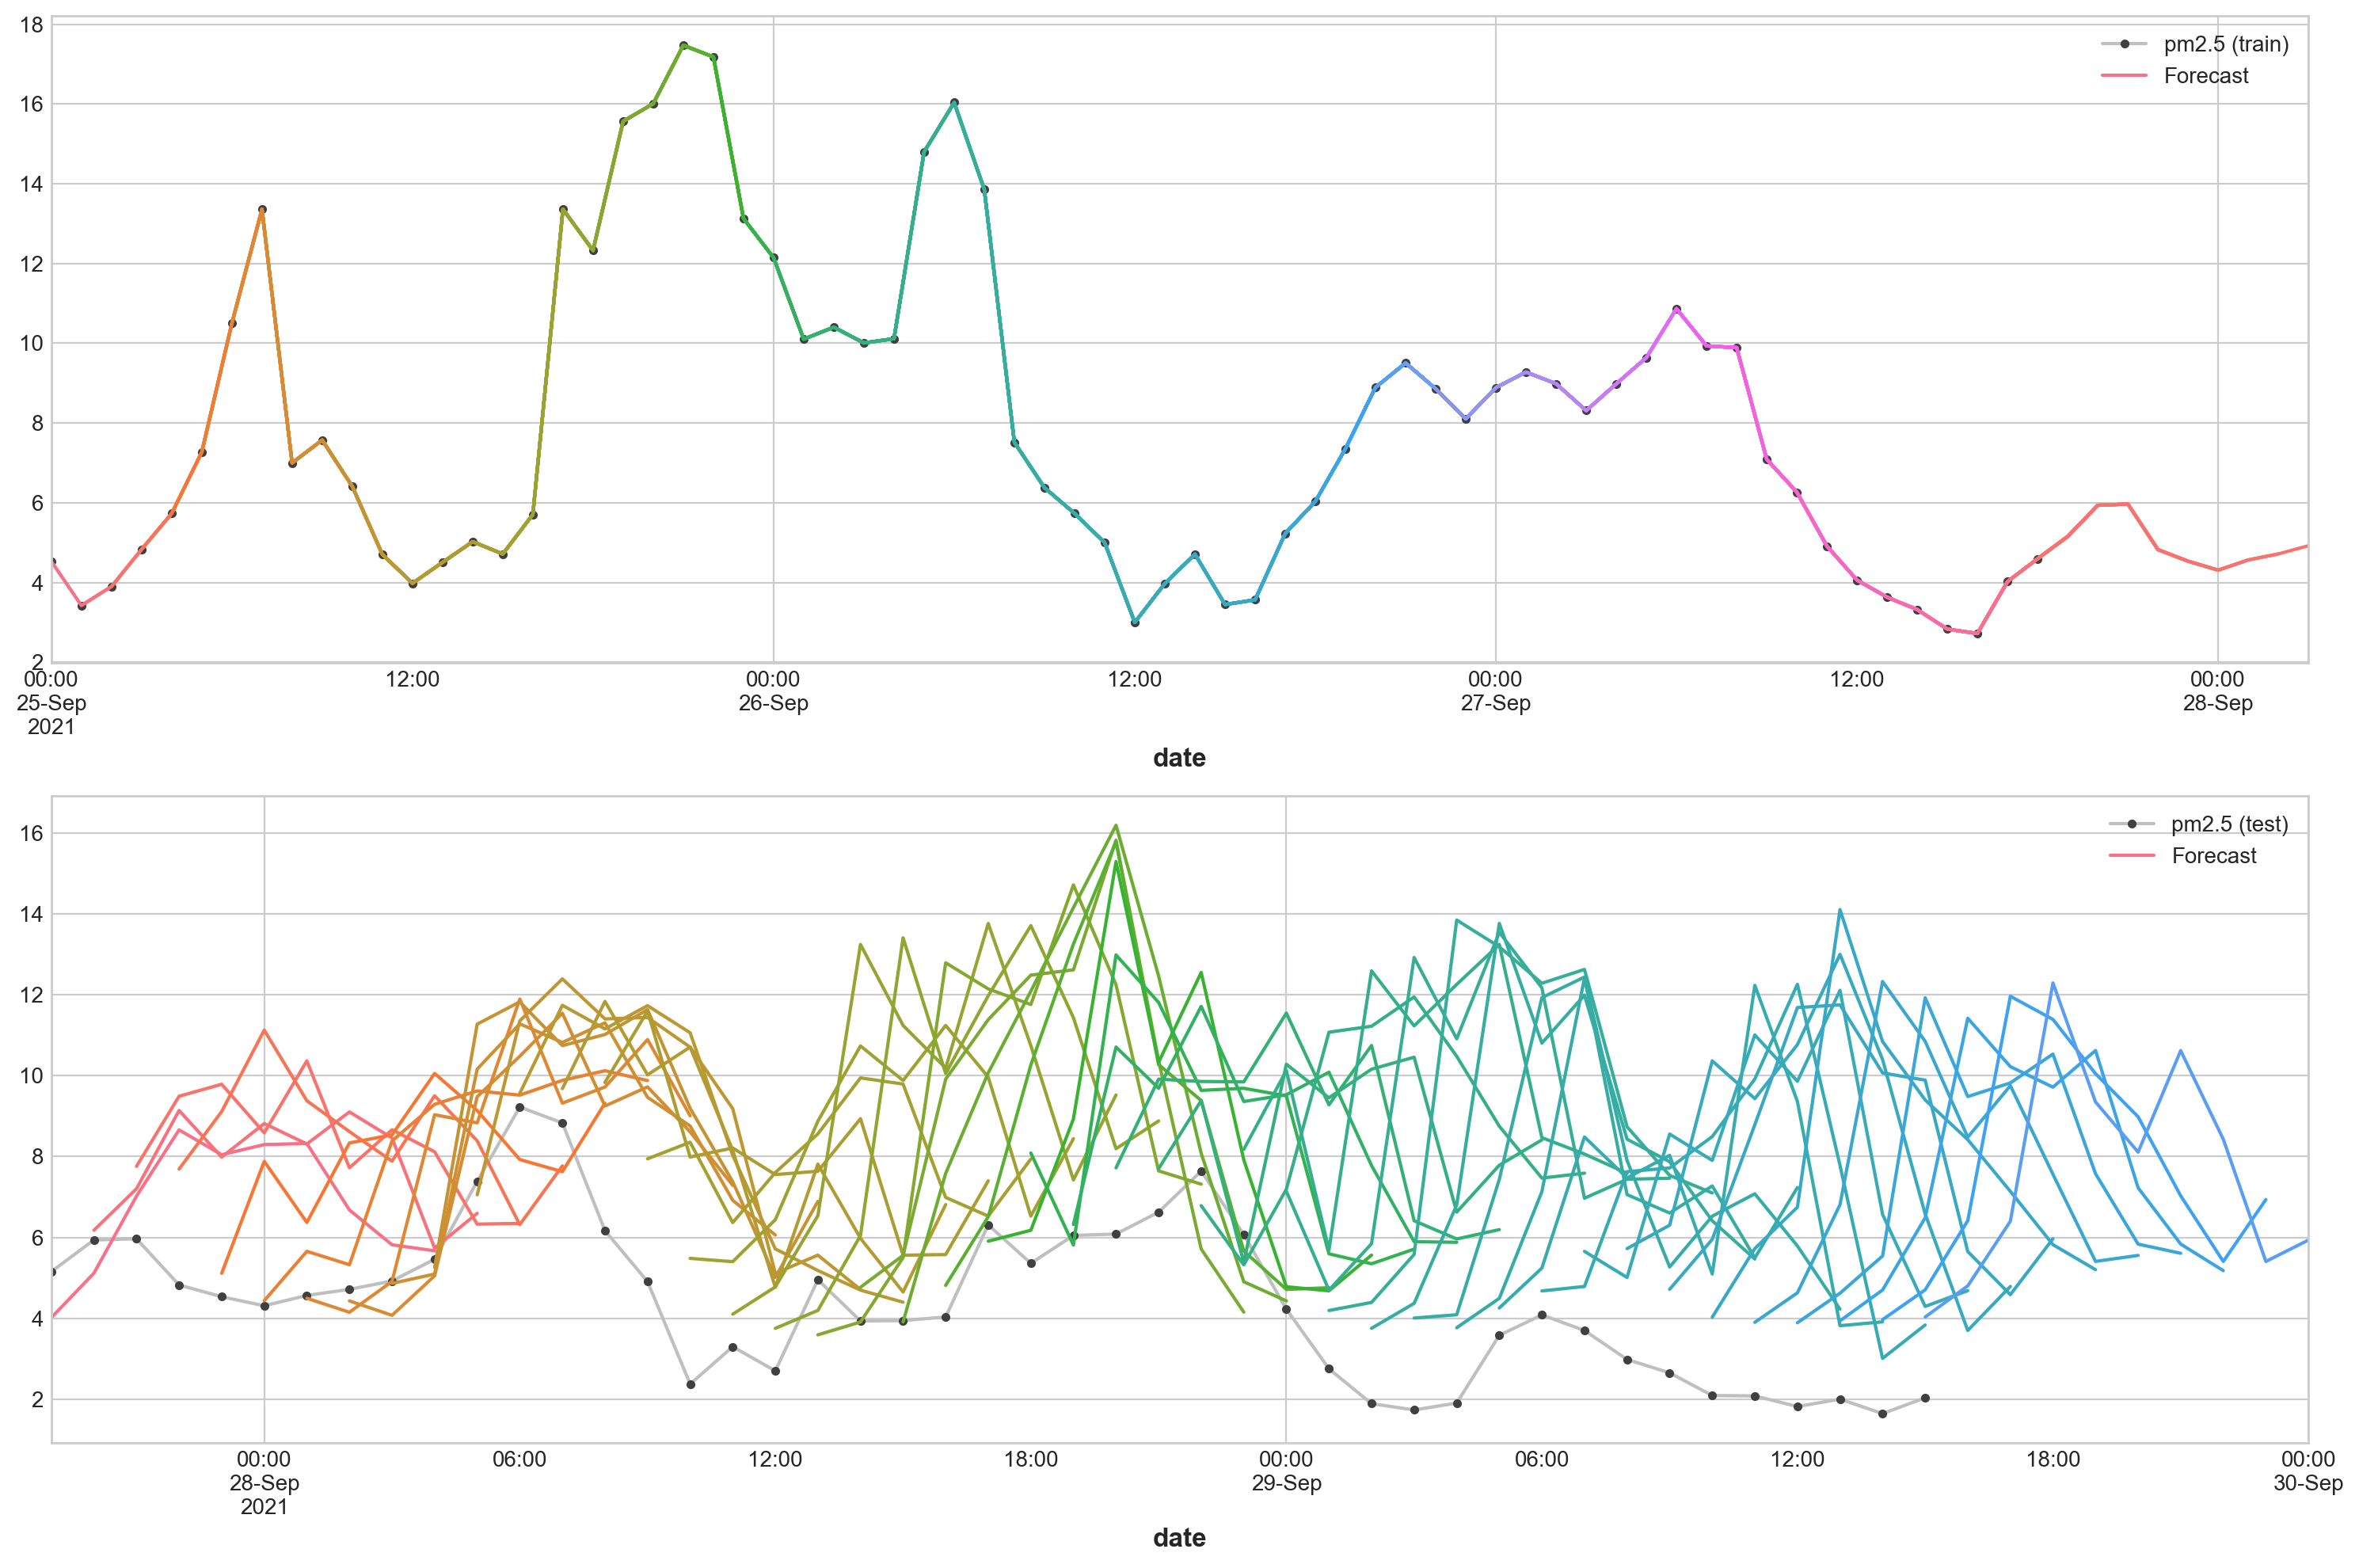

In [9]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1 = merge_data_pc_industrial['pm2.5'][y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['pm2.5 (train)', 'Forecast'])

ax2 = merge_data_pc_industrial['pm2.5'][y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['pm2.5 (test)', 'Forecast'])

# Residential Area

#### Lags and steps of residential postal code

In [10]:
# Four weeks of lag features
y = merge_data_pc_residential['pm2.5'].copy()
X = make_lags(y, lags=24).fillna(0.0)

# Eight-week forecast
y = make_multistep_target(y, steps=10).dropna()
y, X = y.align(X, join='inner', axis=0)

# print(X)
# print(y)

In [11]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)

y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 0.00
Test RMSE: 3.23


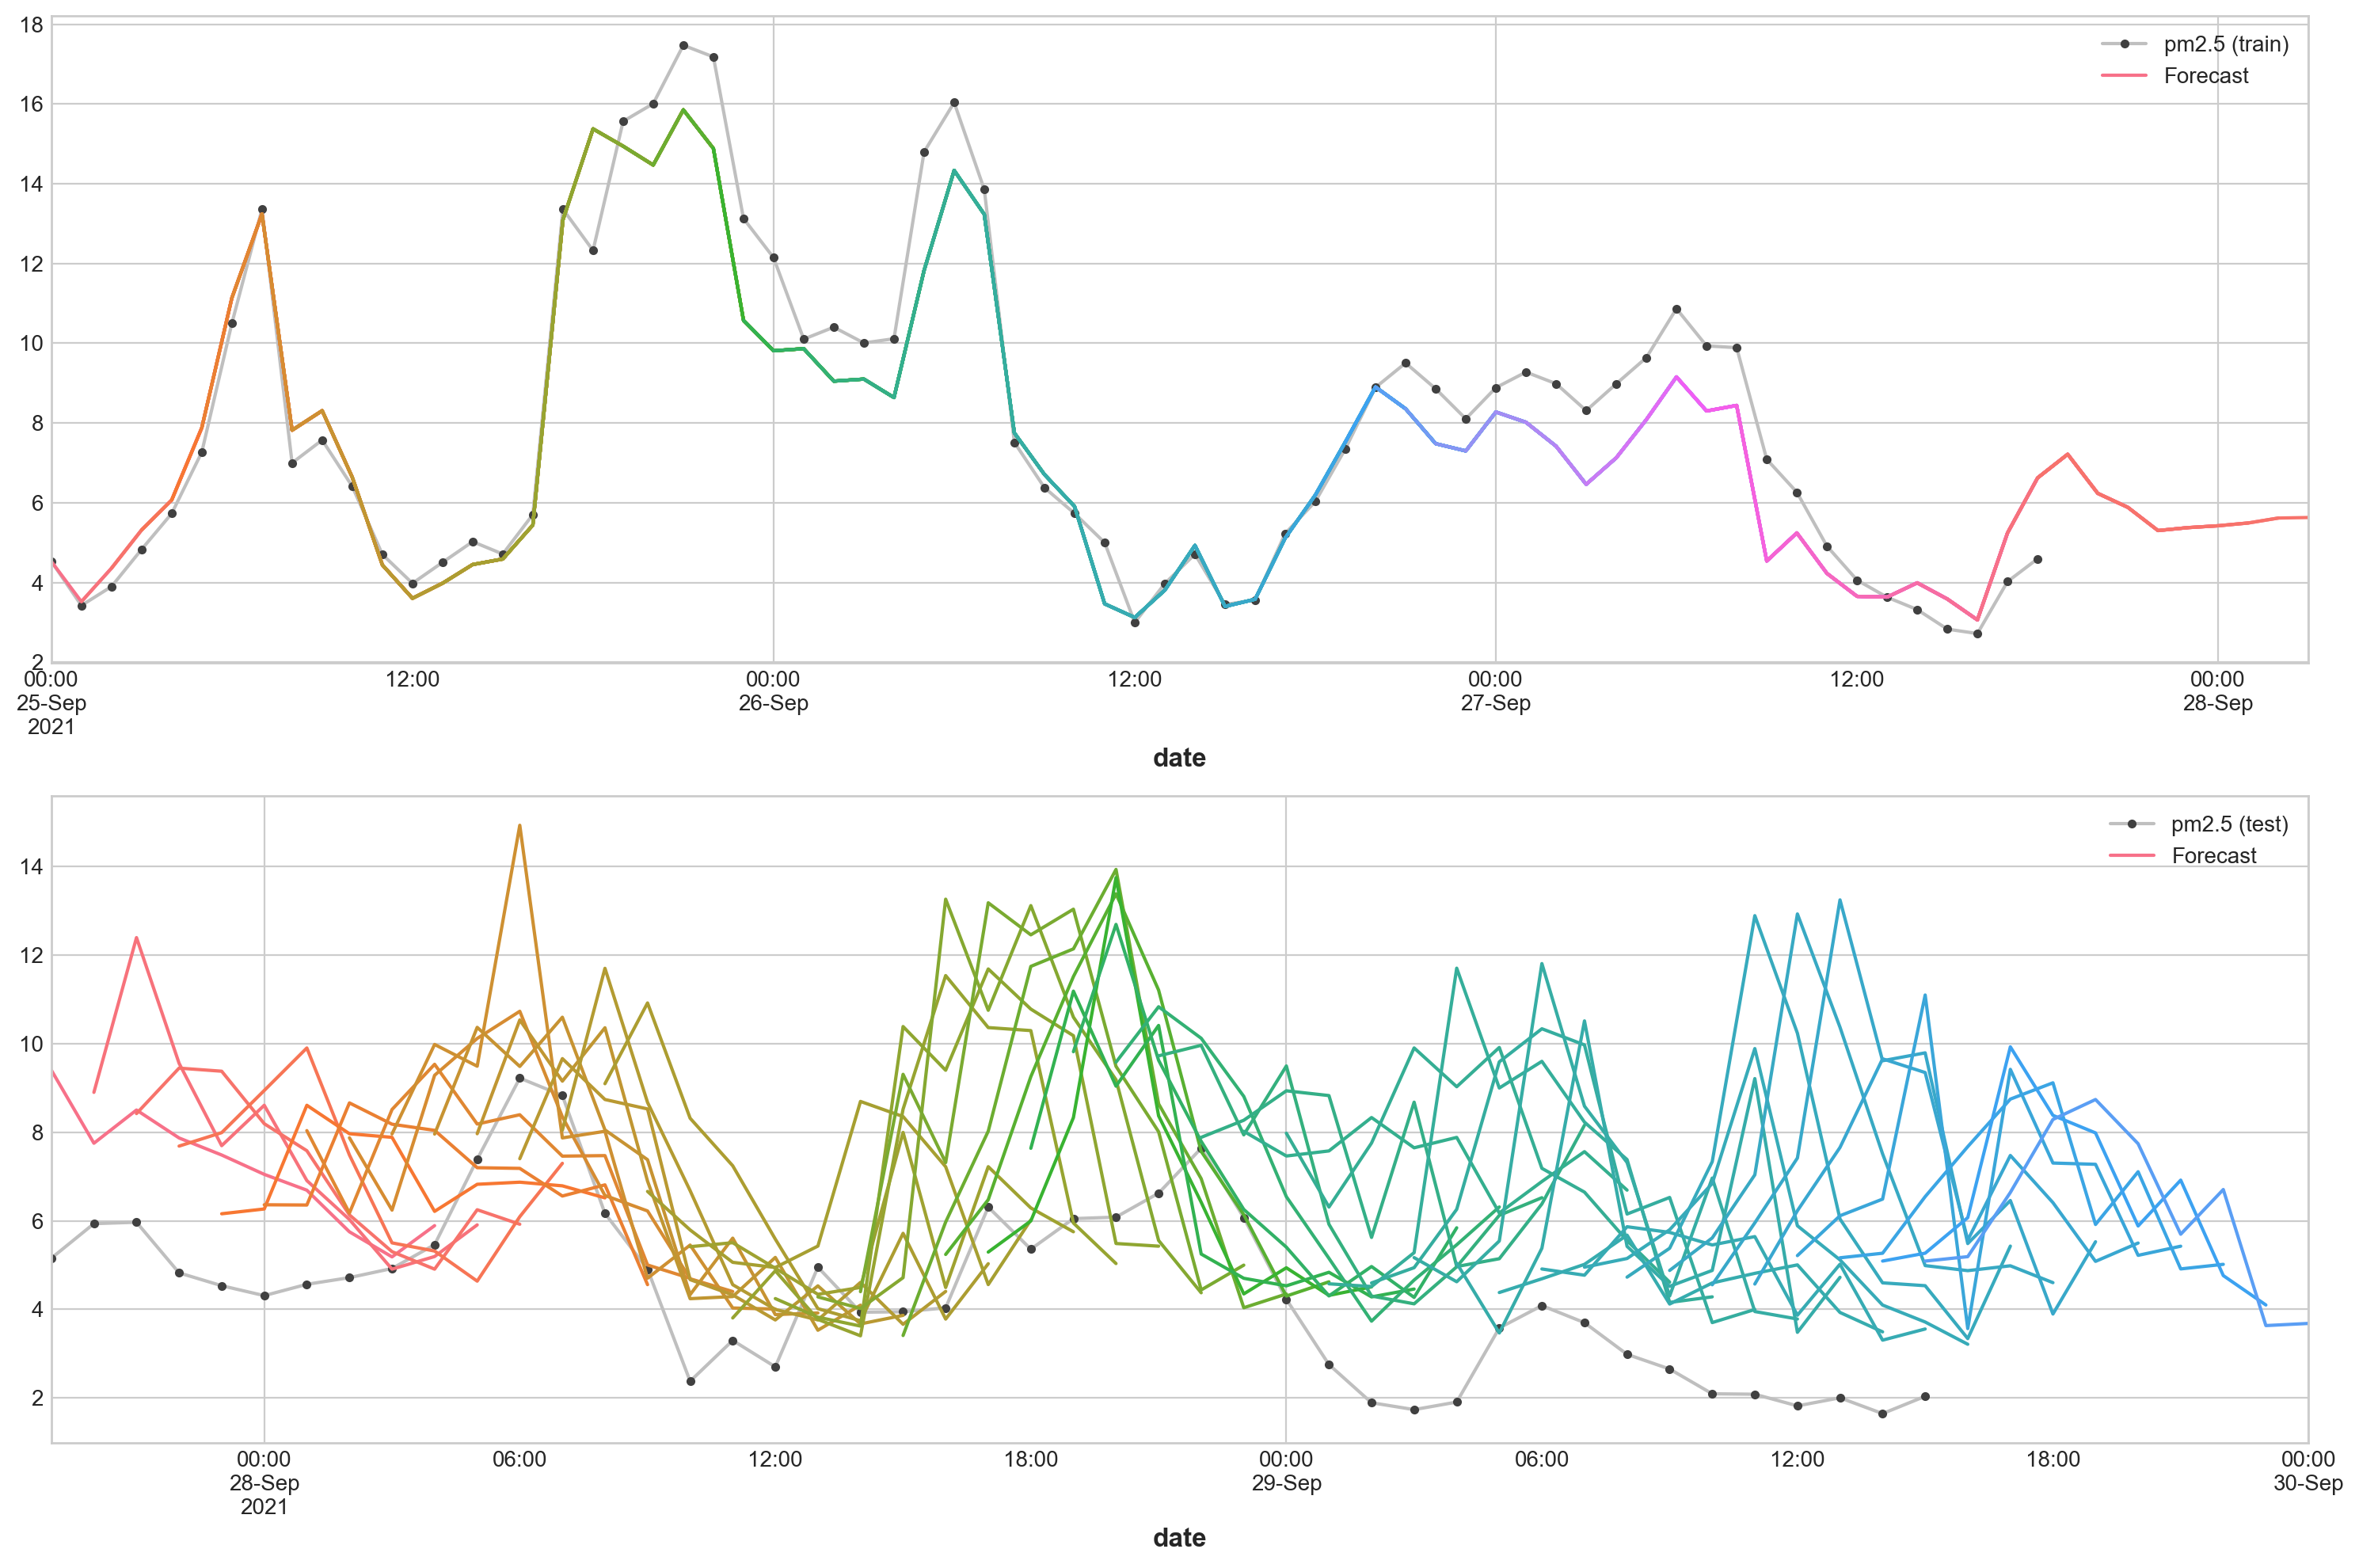

In [12]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1 = merge_data_pc_industrial['pm2.5'][y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['pm2.5 (train)', 'Forecast'])

ax2 = merge_data_pc_industrial['pm2.5'][y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['pm2.5 (test)', 'Forecast'])

# Center Area

#### Lags and steps for the center postal code

In [13]:
# Four weeks of lag features
y = merge_data_pc_center['pm2.5'].copy()
X = make_lags(y, lags=24).fillna(0.0)

# Eight-week forecast
y = make_multistep_target(y, steps=10).dropna()
y, X = y.align(X, join='inner', axis=0)

# print(X)
# print(y)

In [14]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)

y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 0.00
Test RMSE: 3.34


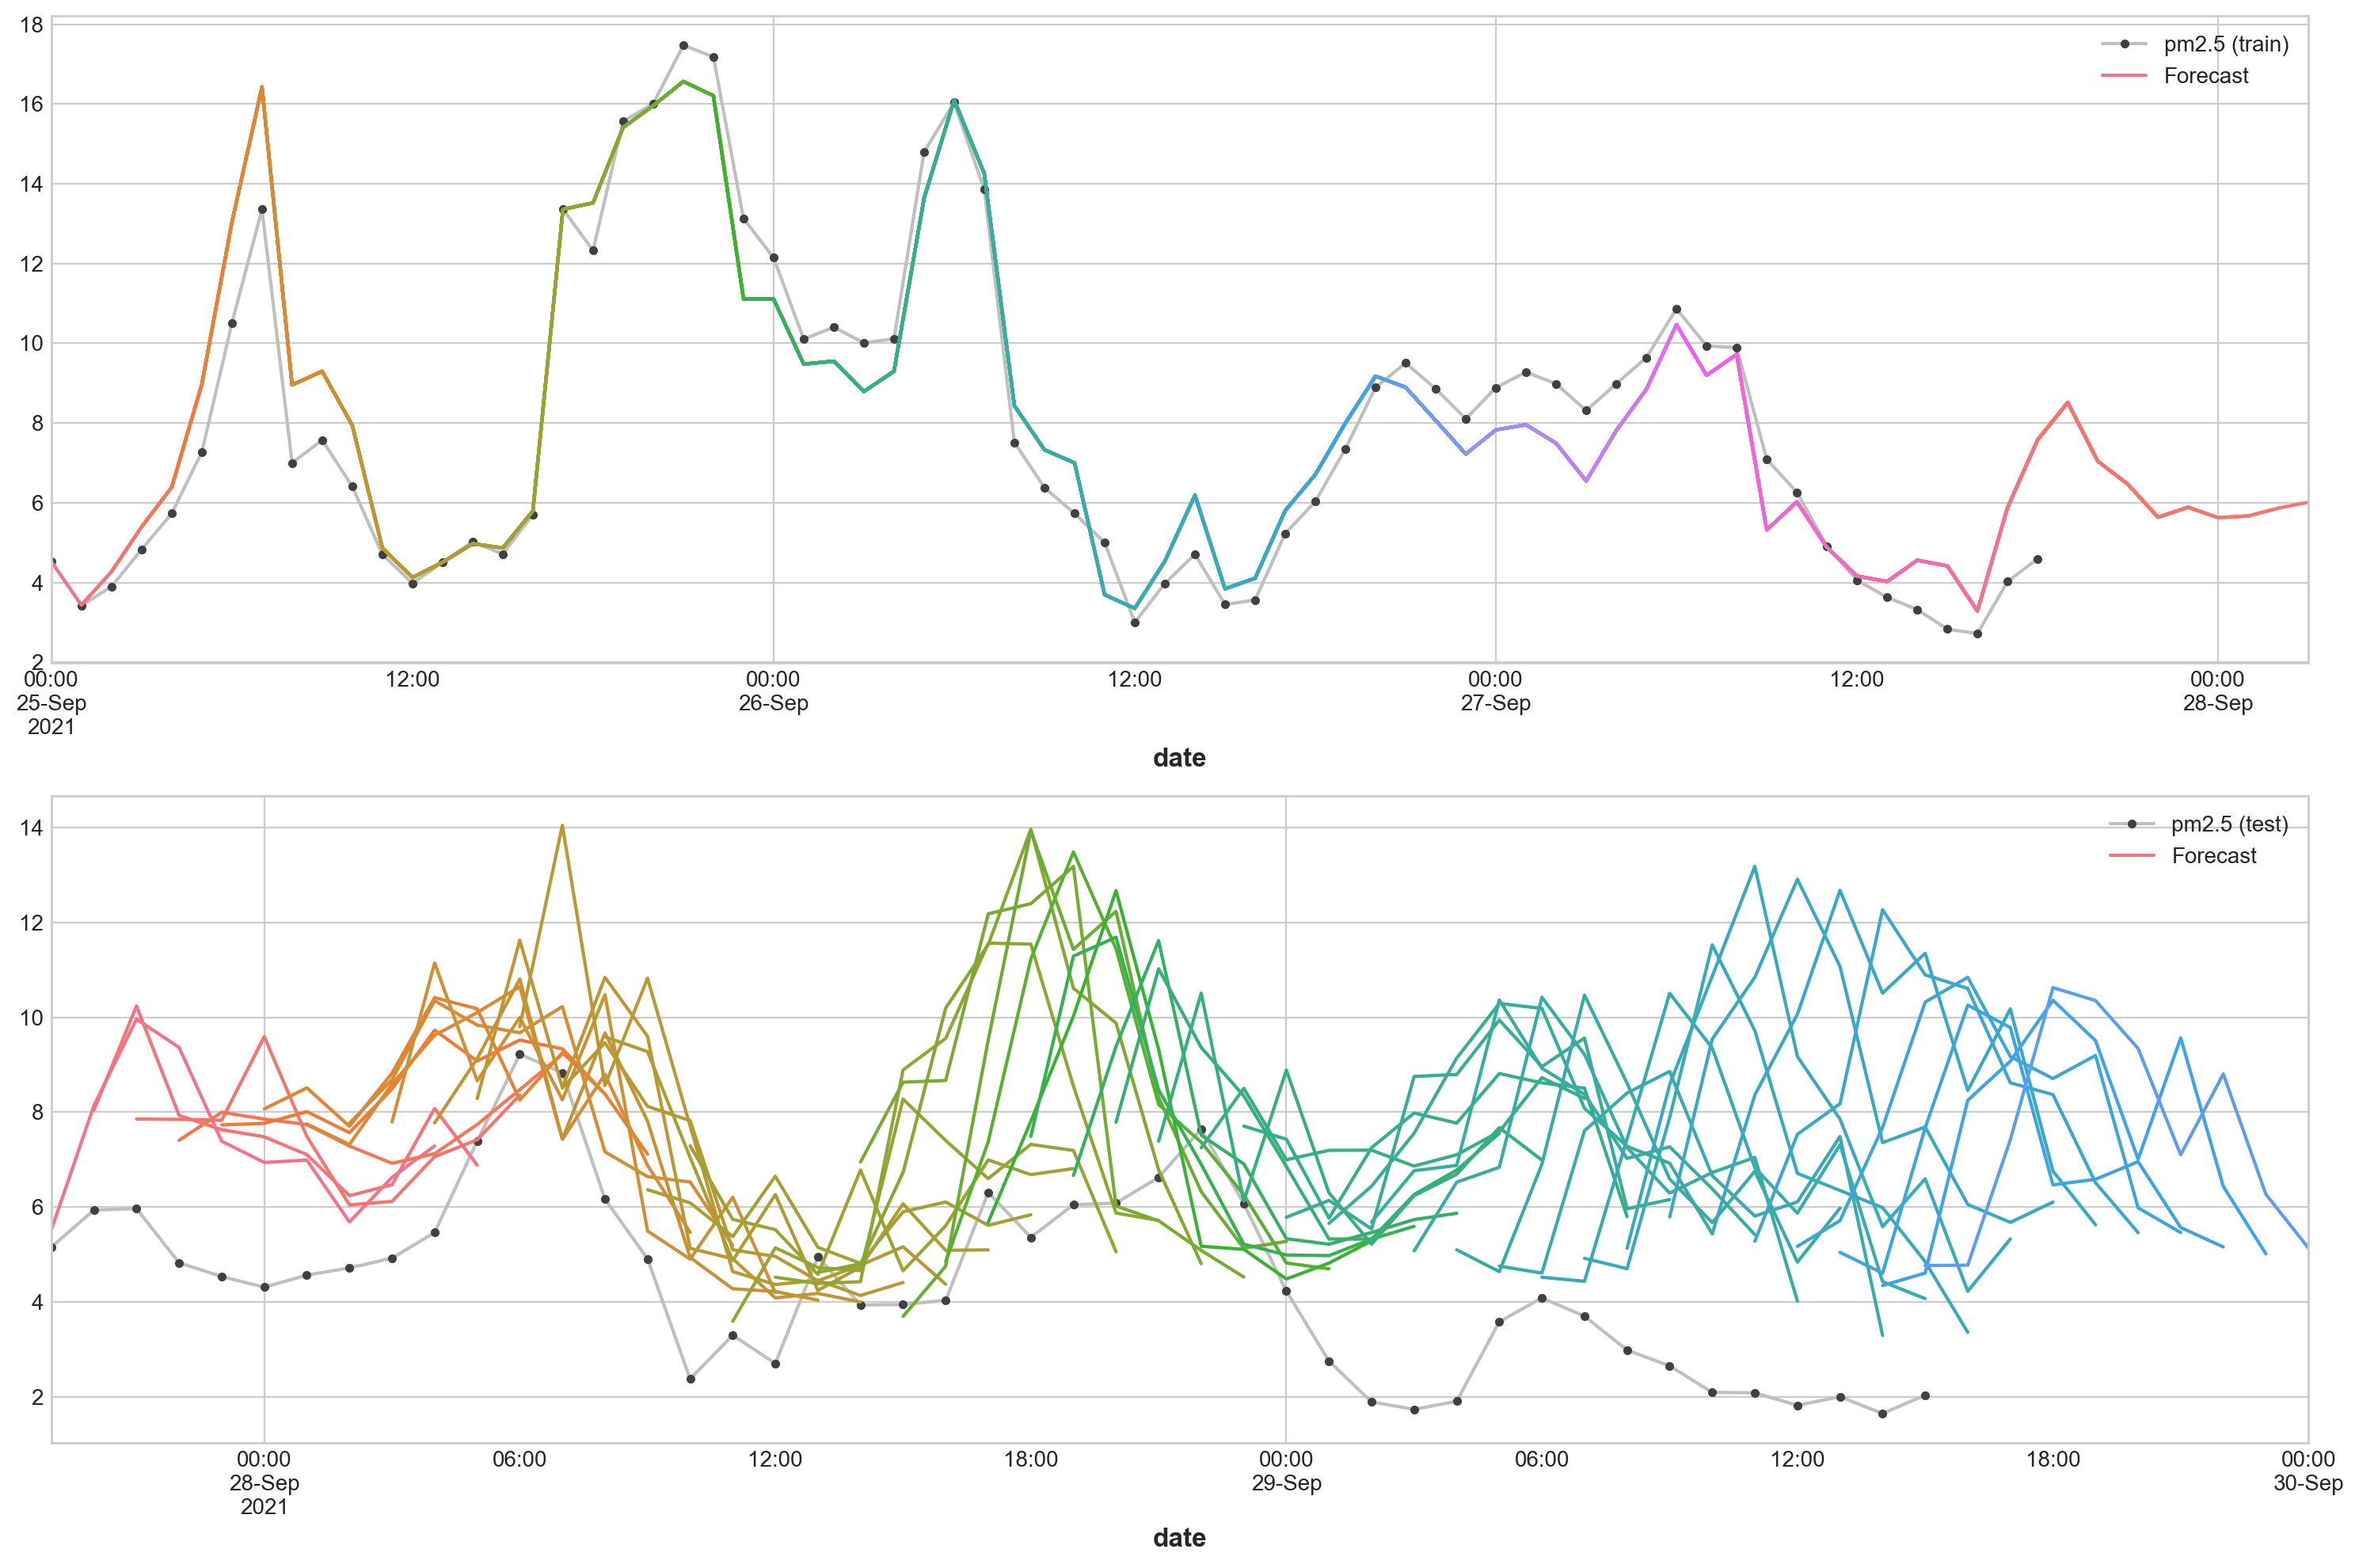

In [15]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1 = merge_data_pc_industrial['pm2.5'][y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['pm2.5 (train)', 'Forecast'])

ax2 = merge_data_pc_industrial['pm2.5'][y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['pm2.5 (test)', 'Forecast'])